# Loading up the dataset
### We'll be using house-room-streets-image-dataset from kaggle for this autoencoder reconstruction trial

In [1]:
import tensorflow as tf

In [2]:
import numpy as np 
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow import keras

img_path = "/kaggle/input/house-rooms-streets-image-dataset/kaggle_room_street_data/house_data"
images = []

for image in os.listdir(img_path):
    if image.endswith(".jpg"):
        img = Image.open(os.path.join(img_path, image))  # Resize to (28, 28) if needed
        img_array = np.array(img)  # Convert image to numpy array (28, 28, 3)
        
        # Append to the list
        images.append(img_array)

# Convert the list of images into a numpy array
# image_arrays = np.array(images)

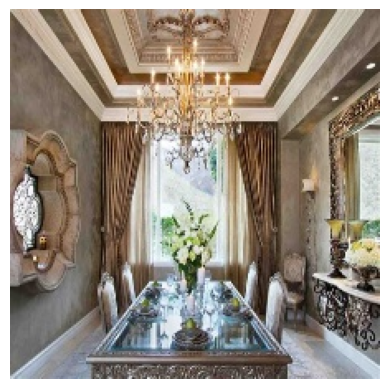

In [6]:
#we're checking the first image in the dataset
plt.imshow(image_arrays[0])
plt.axis("off")
plt.show()

In [8]:
# typically we need to resized and makes sure the image is uniformly sized by 28 x 28 for autoencoders
images_array_resized = np.array([tf.image.resize(img, (32, 32)) for img in image_arrays])

## First step to preprocess the image
### Splitting the dataset into Train and Test Data

In [9]:
#before splitting into train and test, we need to normalize within [1 and 0] value
images_array_resized = images_array_resized.astype('float32') / 255.

In [10]:
print(images_array_resized.shape)

(5249, 32, 32, 3)


In [11]:
from sklearn.model_selection import train_test_split

#spltting for 80 : 20 ratio between train and test
X_train,X_test = train_test_split(images_array_resized, test_size=0.2, random_state=42)

In [12]:
print(X_train.shape)
print(X_test.shape)

(4199, 32, 32, 3)
(1050, 32, 32, 3)


In [ ]:
# #Flattening the image
# X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
# X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

## Making the AutoEncoder Model using TensorFlow

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

input_img = Input(shape=(32, 32, 3))

# Encoder 
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)

# Autoencoder model 
autoencoder = Model(input_img, decoded) 

# Compile the model 
autoencoder.compile(optimizer='adam', loss='binary_crossentropy') 

# Summary of the model 
autoencoder.summary() 

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 52,975 (206.93 KB)

 Trainable params: 52,521 (205.16 KB)

 Non-trainable params: 454 (1.77 KB)

In [14]:
# Now you can train the model
autoencoder.fit(
    X_train, X_train,  
    epochs=50,  
    batch_size=10,  
    shuffle=True,  
    validation_data=(X_test, X_test)
)

Epoch 1/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 26s 49ms/step - loss: 0.6165 - val_loss: 0.5804
Epoch 2/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - loss: 0.5787 - val_loss: 0.5699
Epoch 3/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - loss: 0.5717 - val_loss: 0.5699
Epoch 4/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - loss: 0.5675 - val_loss: 0.5666
Epoch 5/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - loss: 0.5659 - val_loss: 0.5622
Epoch 6/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - loss: 0.5638 - val_loss: 0.5621
Epoch 7/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - loss: 0.5614 - val_loss: 0.5592
Epoch 8/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - loss: 0.5600 - val_loss: 0.5586
Epoch 9/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - loss: 0.5615 - val_loss: 0.5572
Epoch 10/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - loss: 0.5586 - val_loss: 0.5570
Epoch 11/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - loss: 0.5573 - val_loss: 0.5549
Epoch 12/50
420/420 ━━━━━━━━━━

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


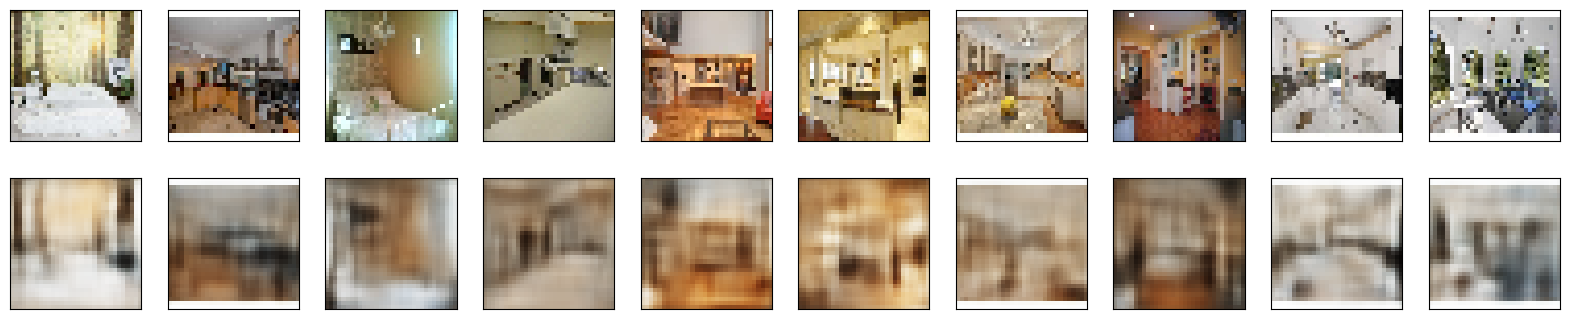

In [17]:
# Predict the test data 
reconstructed = autoencoder.predict(X_test) 

# Visualize the results 
n = 10  # Number of digits to display 
plt.figure(figsize=(20, 4)) 

for i in range(n): 
    # Display original 
    ax = plt.subplot(2, n, i + 1) 
    plt.imshow(X_test[i].reshape(32, 32, 3)) 
    plt.gray() 
    ax.get_xaxis().set_visible(False) 
    ax.get_yaxis().set_visible(False) 

    # Display reconstruction 
    ax = plt.subplot(2, n, i + 1 + n) 
    plt.imshow(reconstructed[i].reshape(32, 32, 3)) 
    plt.gray() 
    ax.get_xaxis().set_visible(False) 
    ax.get_yaxis().set_visible(False) 

plt.show()
